# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

 **Исследование прогнозирования рыночной стоимости автомобилей** 
 
В нашем распоряжении данные о технических характреристиках автомобилей и их стоимости. Имеются данные о модели автомобиля, годе выпуска, типе кузова и т.д.. Чтобы привлечь клиентов, компания разрабатывает приложение, позволяющее на основе основных данных об автомобиле, предсказать его рыночную стоимость.

 **Цель исследования**
 
Цель проекта заключается в разаработке наилучшей модели предсказания стоимости автомобилей, а именно:
1. Проанализировать основную информацию об автомобилях из базы данных.
2. Подготовить данные для обучения моделей.
3. Обучить разные модели и сравнить их быстродействие и качество моделей.
4. Выбрать лучшую модель и проверить ее на тестовой выборке.

**Ход исследования**

Данные для исследования получены из датафрейма, содержащего данные технических характеристиках автоьобилей и их цене. О качестве данных ничего не известно, поэтому понадобится их обзор.

Данные будут проверены на ошибки и пропуски. Неинформативные признаки будут удалены.

Таким образом, исследование будет состоять из следующих этапов:
- обзор данных;
- предобработка данных;
- исследовательский анализ данных;
- предобработка данные для обучения моделей;
- разработка ML - моделей определения стоимости автомобилей;
- выделение наилучшей модели по критериям времени обучения, времени предсказания и качества моделей;
- проверка лучшей модели на тестовой выборке;
- основные выводы.

## Подготовка данных

Загрузка библиотек.

In [1]:
! pip install -q phik

In [2]:
pip install -q catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas==1.3.2 -q # -q убирает необязательные выводы в командах Linux

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
import re
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from typing import Any

import time
warnings.filterwarnings('ignore')

Загрузка датасета.

In [5]:
data = pd.read_csv('/datasets/autos.csv')

In [6]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Данные представлены в виде таблицы, включающей в себя **354369 строк и 16 столбцов** 
При этом 7 столбцов с целочисленными данными  тип < int64 > и 9 столбцов типа < object >.   
Разберём какие в таблице столбцы и какую информацию они содержат:  

**Признаки** 
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя  

**Целевой признак** 
* Price — цена (евро)

В данных имеются пропуски в столбцах(**VehicleType,Model**...), некорректные данные в столбцах(**RegistrationYear**=9999). Требуется предобработка данных.

DateCrawled, DateCreated, PostalCode, NumberOfPictures, LastSeen

Данные столбцы можно смело удалить, они никак не влияют на стоимость автомобиля.

In [9]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
(data['DateCrawled']).max()

Timestamp('2016-04-07 14:36:58')

In [10]:
data=data.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'NumberOfPictures', 'LastSeen','RegistrationMonth'], axis=1)

In [11]:
data.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN


Продолжим анализ данных, восполнив пропуски, отбросив аномальные значения и проведя дополнительные шаги предобработки данных.

Приведем названия столбцов к принятому виду.

In [12]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in data.columns]

In [13]:
data.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN


# price

In [14]:
data['price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

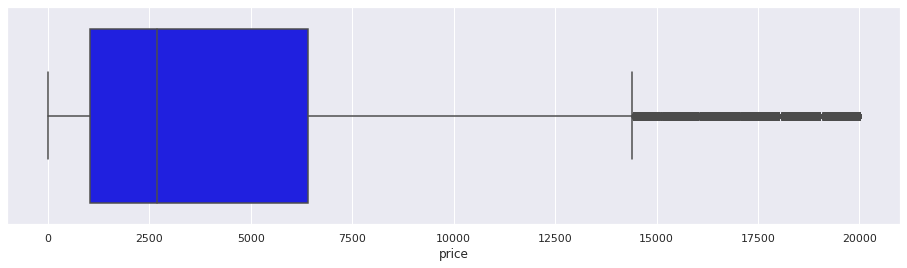

In [15]:
sns.set()
plt.subplots(figsize=(16,4))
sns.boxplot(data['price'], color="blue")
plt.show()

In [16]:
len(data[(data['price'] == 0)])

10772

Определим нижний порог стоимости автомобиля в 100 евро. 

In [17]:
data= data.query('100 <= price')
data['price'].describe()

count    341055.000000
mean       4588.861052
std        4514.844700
min         100.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

# vehicle_type

In [18]:
data['vehicle_type'].value_counts()

sedan          89087
small          77444
wagon          63465
bus            28265
convertible    19817
coupe          15555
suv            11762
other           3048
Name: vehicle_type, dtype: int64

In [19]:
data[(data['vehicle_type'].isnull())]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no
31,899,NaN,2016,manual,60,clio,150000,petrol,renault,NaN
...,...,...,...,...,...,...,...,...,...,...
354338,180,NaN,1995,NaN,0,NaN,125000,petrol,opel,NaN
354346,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354351,1900,NaN,2000,manual,110,NaN,150000,NaN,volkswagen,no
354361,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no


Пропусков много, удалять такой объем информации нельзя. Выполним замену NaN на unknown.

In [20]:
data['vehicle_type'] = data['vehicle_type'].fillna('unknown')

# registration_year

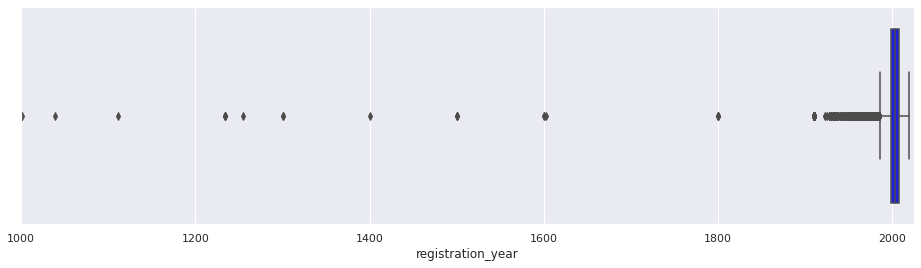

In [21]:
sns.set()
plt.subplots(figsize=(16,4))
sns.boxplot(data['registration_year'], color="blue")
plt.xlim(1000, 2025)
plt.show()

In [22]:
data['registration_year'].describe()

count    341055.000000
mean       2003.955303
std          69.811742
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Имеются неадекватные значения в дате регистрации. Сохраним только те машины, чей год регистрации находится в диапазоне с 1930 по 2021 гг.

In [23]:
data= data.query('1930 <= registration_year <= 2016')

# gearbox

In [24]:
data['gearbox'].value_counts()

manual    249893
auto       62811
Name: gearbox, dtype: int64

Выполним замену NaN на unknown.

In [25]:
data['gearbox'] = data['gearbox'].fillna('unknown')

# power

In [26]:
data['power'].describe()

count    327279.000000
mean        112.349375
std         185.287229
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

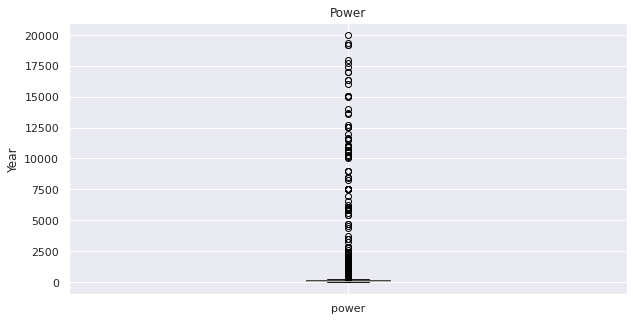

In [27]:
data.boxplot('power', figsize=(10,5))
plt.title('Power')
plt.ylabel('Year')
plt.xlabel('')
plt.show()

Удалим мощность равную более 1000 л.с., так как легковых авто с такой мощностью не бывает.

In [28]:
data = data[data['power']<=1000]

# model, fuel_type

Заменим пропуски в данных о модели и типе топлива на неизвестно.

In [29]:
data['model'] = data['model'].fillna('unknown')
data['fuel_type'] = data['fuel_type'].fillna('unknown')

# repaired

In [30]:
data['repaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

Введем предположение, что пропуски это отсуствие ремонта.

In [31]:
data['repaired'] = data['repaired'].fillna('no')

Заменим да и нет на бинарную классификацию.

In [32]:
data.loc[data['repaired'] == 'yes', 'repaired'] = 1
data.loc[data['repaired'] == 'no', 'repaired'] = 0
data['repaired'] = data['repaired'].astype('int64')
data['repaired'].sort_values().unique()

array([0, 1])

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327020 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              327020 non-null  int64 
 1   vehicle_type       327020 non-null  object
 2   registration_year  327020 non-null  int64 
 3   gearbox            327020 non-null  object
 4   power              327020 non-null  int64 
 5   model              327020 non-null  object
 6   kilometer          327020 non-null  int64 
 7   fuel_type          327020 non-null  object
 8   brand              327020 non-null  object
 9   repaired           327020 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 27.4+ MB


In [34]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [35]:
data.duplicated().sum()

48679

Удалим дубликаты в данных.

In [36]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278341 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              278341 non-null  int64 
 1   vehicle_type       278341 non-null  object
 2   registration_year  278341 non-null  int64 
 3   gearbox            278341 non-null  object
 4   power              278341 non-null  int64 
 5   model              278341 non-null  object
 6   kilometer          278341 non-null  int64 
 7   fuel_type          278341 non-null  object
 8   brand              278341 non-null  object
 9   repaired           278341 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 23.4+ MB


Посмотрим корреляцию между признаками.

In [37]:
data\
    .corr()\
    .style\
    .background_gradient(cmap='coolwarm')

,price,registration_year,power,kilometer,repaired
price,1.000000,0.428672,0.472872,-0.350990,-0.199769
registration_year,0.428672,1.000000,0.142729,-0.216878,-0.084551
power,0.472872,0.142729,1.000000,0.092543,-0.050980
kilometer,-0.350990,-0.216878,0.092543,1.000000,0.081135
repaired,-0.199769,-0.084551,-0.050980,0.081135,1.000000


In [38]:
data.phik_matrix() 

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'repaired']


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
price,1.000000,0.273810,0.590568,0.289591,0.468780,0.569917,0.302860,0.256083,0.360794,0.308634
vehicle_type,0.273810,1.000000,0.202370,0.506034,0.425300,0.893472,0.270688,0.407029,0.587414,0.049706
registration_year,0.590568,0.202370,1.000000,0.124110,0.189060,0.578760,0.349716,0.211163,0.390422,0.138768
gearbox,0.289591,0.506034,0.124110,1.000000,0.428576,0.618165,0.168503,0.317880,0.511472,0.015703
power,0.468780,0.425300,0.189060,0.428576,1.000000,0.683585,0.104125,0.222272,0.479077,0.065308
model,0.569917,0.893472,0.578760,0.618165,0.683585,1.000000,0.436467,0.543190,0.997776,0.123445
kilometer,0.302860,0.270688,0.349716,0.168503,0.104125,0.436467,1.000000,0.172679,0.278694,0.095831
fuel_type,0.256083,0.407029,0.211163,0.317880,0.222272,0.543190,0.172679,1.000000,0.328745,0.050865
brand,0.360794,0.587414,0.390422,0.511472,0.479077,0.997776,0.278694,0.328745,1.000000,0.082002
repaired,0.308634,0.049706,0.138768,0.015703,0.065308,0.123445,0.095831,0.050865,0.082002,1.000000


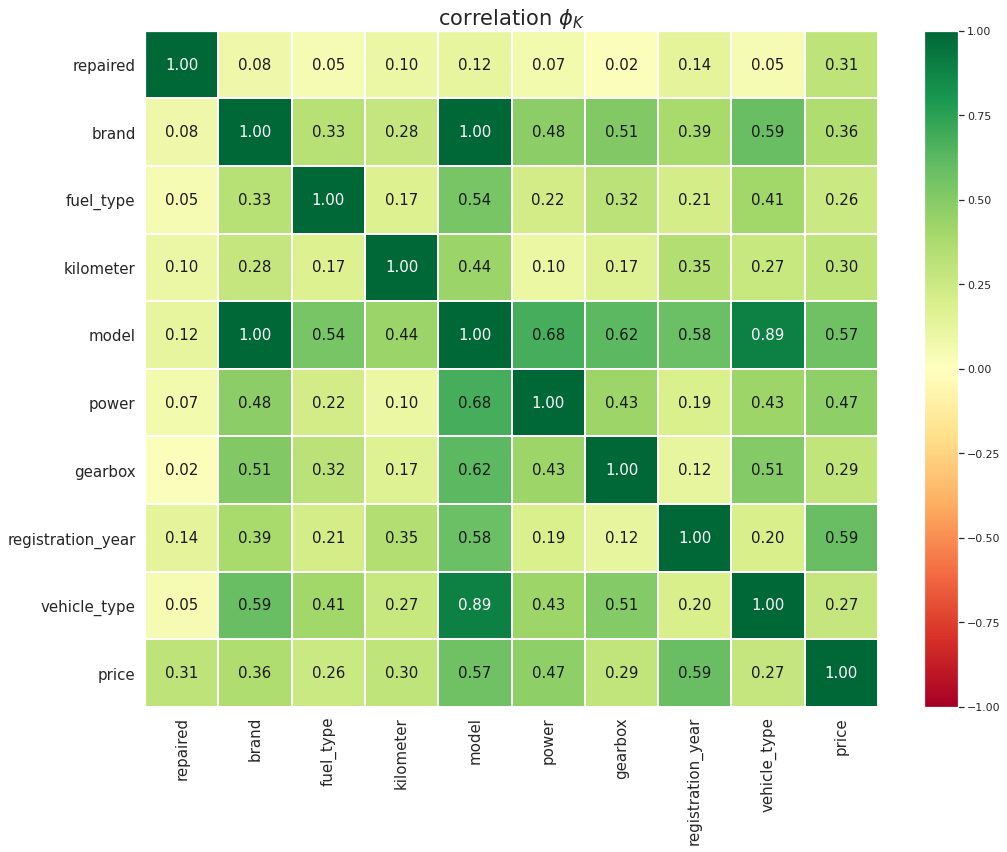

In [39]:
# список интервальных признаков
interval_cols = ['price', 'registration_year', 'power', 'kilometer', 'repaired']

# вычисление коэффициентов корреляции phi для датафрейма data
phik_overview = data.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
) 

В разделе Исследование данных были выполнены следующие задачи:.

Произведено изучение данных

Удалены явные дубликаты

Исключены неинформативные признаки

Проведено исследование данных после первоначальной предобработки

Произведена обработка аномалий

Обработаны пропущенные значения

Установлено, что цена зависит от основных признаков, причем высокие показатели года регистрации и мощности увеличивают цену, а пробег и наличие ремонта ее снижают.

## Обучение моделей

 Создадим функцию разбиения выборок на обучающую, валидационную и тестовую в соотношении 60:20:20.

In [40]:
def split(data: pd.DataFrame) -> pd.array:
    features_train, features_test, target_train, target_test = train_test_split(
        data.drop('price', axis=1), data.price, test_size=0.25, random_state=42
    )
    return features_train, features_test, target_train, target_test

Т.к проверка наших моделей будет осуществляться метрикой RMSE, создадим для нее функцию и определим переменной scorer ссылку на объект с наилучшим результатом.

In [41]:
def rmse_score(target: pd.array, predictions: pd.array) -> float:
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse

In [42]:
scorer = make_scorer(rmse_score, greater_is_better=False)

Функция обучения наших моделей, поиска наилучшей метрики RMSE и подобранных параметров.

In [43]:
def model_look(model: Any, parameters: list, features_train: pd.array, target_train: pd.array):
    model_grid = GridSearchCV(model, parameters, cv=5, scoring=scorer, verbose=5)
    model_grid.fit(features_train, target_train)
    return model_grid.best_score_, model_grid.best_params_

In [44]:
type(LinearRegression())

sklearn.linear_model._base.LinearRegression

# Линейная регрессия

Преобразуем категориальные данные методом прямого кодирования для обучения модели линейной регрессии.

In [45]:
data_lr = data.copy()

In [46]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = split(data_lr)

In [47]:
linear_transformer = make_column_transformer(
    (
        OneHotEncoder(
            dtype='uint8',
            handle_unknown='ignore'
        ), make_column_selector(dtype_include='object')
    ),
    (
        StandardScaler(
        ), make_column_selector(dtype_include='number')
    ),
    remainder='passthrough'
)

In [48]:
pipe_lr = make_pipeline(
    linear_transformer,
    LinearRegression(
        n_jobs=-1
    )
)

In [49]:
param_grid = {
    'linearregression__normalize':[False, True]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

Обучим модель линейной регрессии и узнаем лучшую метрику RMSE и параметры.

In [50]:
%time gs_lr.fit(features_train_lr, target_train_lr)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 1min 3s, sys: 1min 1s, total: 2min 5s
Wall time: 2min 36s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(dtype='uint8',
                                                                                       handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f16c32a5670>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f169411a3a0>)])),
                                       ('linearregression',
                                        LinearRegression(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'linearregression__normalize': [False, True]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [51]:
gs_lr.best_params_

{'linearregression__normalize': True}

In [52]:
gs_lr.best_score_

-2786.7276751338286

In [53]:
pd.DataFrame(gs_lr.cv_results_)[[
    'param_linearregression__normalize',
    'mean_test_score'
]]

,param_linearregression__normalize,mean_test_score
0,False,-2786.734881
1,True,-2786.727675


In [54]:
results = pd.DataFrame(
    {
        'model':['LinearRegression'],
        'best_parameters_train':[gs_lr.best_params_],
        'RMSE_train':[gs_lr.best_score_]
    }
)

Проверим работу модели предсказаний на моделе дерева решений. Т.к. для деревянных моделей подходит больше кодирование признаков порядковым кодированием, подготовим дланные.

In [55]:
data_tree = data.copy()

In [56]:
features_train_tree, features_test_tree, target_train_tree, target_test_tree\
    = split(data_tree)

In [58]:
cat_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'brand', 'model']
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
data_ordinal = features_train_tree
data_ordinal[cat_columns] = encoder.fit_transform(data_ordinal[cat_columns])
data_ordinal.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
23125,8.0,2001,1.0,110,116.0,150000,7.0,38.0,0.0
150238,5.0,2001,1.0,82,33.0,150000,6.0,20.0,0.0
149139,4.0,2004,0.0,170,15.0,150000,6.0,2.0,0.0
294706,4.0,2000,1.0,150,11.0,150000,6.0,2.0,0.0
178410,5.0,2004,2.0,60,228.0,150000,6.0,9.0,0.0


In [ ]:
parameters = {'max_depth': range(18,21), 'min_samples_split': range(44,47)}
rmse, best_parameters = model_look(DecisionTreeRegressor(random_state=42),\
                                    parameters, data_ordinal, target_train_tree)
display('Лучшие параметры модели дерева решений:', best_parameters)
display('RMSE модели:', rmse)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
results = pd.concat(
    [
        results, pd.DataFrame({
        'model':'DecisionTreeRegressor',
        'best_parameters_train':[best_parameters],
        'RMSE_train':rmse
    })
    ], ignore_index=True
)
results

Проверим работу модели предсказаний на моделе случайного леса.

In [57]:
parameters = {'n_estimators': range(143, 146, 1), 'max_depth': range(17,20, 1)}
rmse, best_parameters = model_look(RandomForestRegressor(random_state=12345), \
                                    parameters, data_ordinal, target_train_tree)
display('Лучшие параметры модели случайного леса:', best_parameters)
display('RMSE модели:', rmse)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .................max_depth=17, n_estimators=143; total time=  54.4s
[CV 2/5] END .................max_depth=17, n_estimators=143; total time=  54.6s
[CV 3/5] END .................max_depth=17, n_estimators=143; total time=  54.4s
[CV 4/5] END .................max_depth=17, n_estimators=143; total time=  54.1s
[CV 5/5] END .................max_depth=17, n_estimators=143; total time=  54.0s
[CV 1/5] END .................max_depth=17, n_estimators=144; total time=  54.1s
[CV 2/5] END .................max_depth=17, n_estimators=144; total time=  54.0s
[CV 3/5] END .................max_depth=17, n_estimators=144; total time=  53.9s
[CV 4/5] END .................max_depth=17, n_estimators=144; total time=  53.9s
[CV 5/5] END .................max_depth=17, n_estimators=144; total time=  54.6s
[CV 1/5] END .................max_depth=17, n_estimators=145; total time=  54.5s
[CV 2/5] END .................max_depth=17, n_est

'Лучшие параметры модели случайного леса:'

{'max_depth': 18, 'n_estimators': 144}

'RMSE модели:'

-1727.5412123962954

In [58]:
results = pd.concat(
    [
        results, pd.DataFrame({
        'model':'RandomForestRegressor',
        'best_parameters_train':[best_parameters],
        'RMSE_train':rmse
    })
    ], ignore_index=True
)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,{'linearregression__normalize': True},-2786.727657
1,DecisionTreeRegressor,"{'max_depth': 20, 'min_samples_split': 45}",-1913.962056
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1727.541212


Проверим работу модели предсказаний на моделе CatBoostRegressor. Для этого переведем значения категориальных столбцов в тип 'category'.

In [59]:
data_catboost = data.copy()
for columns in cat_columns:
    data_catboost[columns] = data_catboost[columns].astype('category')
data_catboost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278341 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              278341 non-null  int64   
 1   vehicle_type       278341 non-null  category
 2   registration_year  278341 non-null  int64   
 3   gearbox            278341 non-null  category
 4   power              278341 non-null  int64   
 5   model              278341 non-null  category
 6   kilometer          278341 non-null  int64   
 7   fuel_type          278341 non-null  category
 8   brand              278341 non-null  category
 9   repaired           278341 non-null  category
dtypes: category(6), int64(4)
memory usage: 12.5 MB


In [60]:
features_train, features_test, target_train, target_test = split(data_catboost)

In [61]:
parameters = {'depth': range(5, 9, 1), 'iterations': range(900, 1200, 100)}
rmse, best_parameters = model_look(
    CatBoostRegressor(
        cat_features=cat_columns,
        loss_function="RMSE",
        learning_rate=0.5,
        logging_level='Silent'),
    parameters, features_train, target_train
)
display('Лучшие параметры модели CatBoostRegressor:', best_parameters)
display('RMSE модели:', rmse)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ........................depth=5, iterations=900; total time= 2.1min
[CV 2/5] END ........................depth=5, iterations=900; total time= 2.1min
[CV 3/5] END ........................depth=5, iterations=900; total time= 2.1min
[CV 4/5] END ........................depth=5, iterations=900; total time= 2.1min
[CV 5/5] END ........................depth=5, iterations=900; total time= 2.1min
[CV 1/5] END .......................depth=5, iterations=1000; total time= 2.3min
[CV 2/5] END .......................depth=5, iterations=1000; total time= 2.3min
[CV 3/5] END .......................depth=5, iterations=1000; total time= 2.3min
[CV 4/5] END .......................depth=5, iterations=1000; total time= 2.4min
[CV 5/5] END .......................depth=5, iterations=1000; total time= 2.4min
[CV 1/5] END .......................depth=5, iterations=1100; total time= 2.5min
[CV 2/5] END .......................depth=5, ite

'Лучшие параметры модели CatBoostRegressor:'

{'depth': 6, 'iterations': 1100}

'RMSE модели:'

-1662.5799790897624

In [62]:
results = pd.concat(
    [
        results, pd.DataFrame({
        'model':'CatBoostRegressor',
        'best_parameters_train':[best_parameters],
        'RMSE_train':rmse
    })
    ], ignore_index=True
)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,{'linearregression__normalize': True},-2786.727657
1,DecisionTreeRegressor,"{'max_depth': 20, 'min_samples_split': 45}",-1913.962056
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1727.541212
3,CatBoostRegressor,"{'depth': 6, 'iterations': 1100}",-1662.579979


Проверим работу модели предсказаний на моделе LGBMRegressor.

In [63]:
parameters = {'n_estimators': range(2048, 2051)}
rmse, best_parameters = model_look(
    LGBMRegressor(random_state=42, verbose=-1), parameters, features_train, target_train
)
display('Лучшие параметры модели LGBMRegressor:', best_parameters)
display('RMSE модели:', rmse)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..............................n_estimators=2048; total time= 2.5min
[CV 2/5] END ..............................n_estimators=2048; total time= 4.7min
[CV 3/5] END ..............................n_estimators=2048; total time=13.4min
[CV 4/5] END ..............................n_estimators=2048; total time= 3.0min
[CV 5/5] END ..............................n_estimators=2048; total time= 1.6min
[CV 1/5] END ..............................n_estimators=2049; total time= 6.4min
[CV 2/5] END ..............................n_estimators=2049; total time=13.4min
[CV 3/5] END ..............................n_estimators=2049; total time= 1.8min
[CV 4/5] END ..............................n_estimators=2049; total time= 1.8min
[CV 5/5] END ..............................n_estimators=2049; total time= 1.4min
[CV 1/5] END ..............................n_estimators=2050; total time= 1.5min
[CV 2/5] END ..............................n_esti

'Лучшие параметры модели LGBMRegressor:'

{'n_estimators': 2048}

'RMSE модели:'

-1619.2115386588152

In [64]:
results = pd.concat(
    [
        results, pd.DataFrame({
        'model':'LGBMRegressor',
        'best_parameters_train':[best_parameters],
        'RMSE_train':rmse
    })
    ], ignore_index=True
)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,{'linearregression__normalize': True},-2786.727657
1,DecisionTreeRegressor,"{'max_depth': 20, 'min_samples_split': 45}",-1913.962056
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1727.541212
3,CatBoostRegressor,"{'depth': 6, 'iterations': 1100}",-1662.579979
4,LGBMRegressor,{'n_estimators': 2048},-1619.211539


На данном этапе мы выяснили какую метрику выдают модели предсказаний и их лучшие параметры. Лучшие показатели по метрике RSME показала модель LightGBM. Необходимо проверить данные модели с наилучшими параметрами на тестовой выборке.

## Анализ моделей

Создадим функцию для обучения, хронометража обучения и предсказания моделей.

In [65]:
def ml_result(model, features_train, target_train, features_test, target_test):
        
    fit_up = time.time()
    model.fit(features_train, target_train)
    fit_down = time.time()
    
    fit_time = fit_down - fit_up
    
    predict_up = time.time()
    predictions = model.predict(features_test)
    predict_down = time.time()
    
    predict_time = predict_down - predict_up
    
    rmse = mean_squared_error(target_test, predictions)**0.5
      
    return fit_time, predict_time, rmse

Проверим модель линейной регрессии.

In [66]:
%time gs_lr.fit(features_test_lr, target_test_lr)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 28.3 s, sys: 30 s, total: 58.4 s
Wall time: 58.4 s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(dtype='uint8',
                                                                                       handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ec741640>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ec741040>)])),
                                       ('linearr

In [67]:
fit_time, predict_time, rmse = ml_result(
    gs_lr,
    features_train_lr,
    target_train_lr,
    features_test_lr,
    target_test_lr
)
results.loc[0, 'fit_time'] = fit_time
results.loc[0, 'predict_time'] = predict_time
results.loc[0, 'rmse_test'] = rmse
results

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,{'linearregression__normalize': True},-2786.727657,124.240472,0.276665,2769.057477
1,DecisionTreeRegressor,"{'max_depth': 20, 'min_samples_split': 45}",-1913.962056,NaN,NaN,NaN
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1727.541212,NaN,NaN,NaN
3,CatBoostRegressor,"{'depth': 6, 'iterations': 1100}",-1662.579979,NaN,NaN,NaN
4,LGBMRegressor,{'n_estimators': 2048},-1619.211539,NaN,NaN,NaN


Проверим модель дерева решений.

In [74]:
data_ordinal_1 = features_test_tree
data_ordinal_1[cat_columns] = encoder.fit_transform(data_ordinal_1[cat_columns])
data_ordinal_1.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
251200,2.0,2001,0.0,197,59.0,150000,6.0,20.0,0.0
3805,5.0,2002,1.0,61,223.0,40000,6.0,32.0,0.0
193767,8.0,2002,1.0,207,58.0,125000,6.0,5.0,0.0
210087,5.0,2008,1.0,67,146.0,90000,4.0,3.0,1.0
13967,4.0,2001,1.0,75,115.0,80000,6.0,38.0,0.0


In [69]:
fit_time, predict_time, rmse = ml_result(
    DecisionTreeRegressor(random_state=42,
                          max_depth=20,
                          min_samples_split=44),
    features_train_tree, target_train_tree, features_test_tree, target_test_tree)
results.loc[1, 'fit_time'] = fit_time
results.loc[1, 'predict_time'] = predict_time
results.loc[1, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,{'linearregression__normalize': True},-2786.727657,124.240472,0.276665,2769.057477
1,DecisionTreeRegressor,"{'max_depth': 20, 'min_samples_split': 45}",-1913.962056,0.671403,0.021209,1971.250467
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1727.541212,NaN,NaN,NaN
3,CatBoostRegressor,"{'depth': 6, 'iterations': 1100}",-1662.579979,NaN,NaN,NaN
4,LGBMRegressor,{'n_estimators': 2048},-1619.211539,NaN,NaN,NaN


Проверим модель случайного дерева.

In [70]:
fit_time, predict_time, rmse = ml_result(
    RandomForestRegressor(random_state=42,
                          max_depth=18,
                          n_estimators=143),
    features_train_tree, target_train_tree, features_test_tree, target_test_tree)
results.loc[2, 'fit_time'] = fit_time
results.loc[2, 'predict_time'] = predict_time
results.loc[2, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,{'linearregression__normalize': True},-2786.727657,124.240472,0.276665,2769.057477
1,DecisionTreeRegressor,"{'max_depth': 20, 'min_samples_split': 45}",-1913.962056,0.671403,0.021209,1971.250467
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1727.541212,67.104515,2.596824,1737.979200
3,CatBoostRegressor,"{'depth': 6, 'iterations': 1100}",-1662.579979,NaN,NaN,NaN
4,LGBMRegressor,{'n_estimators': 2048},-1619.211539,NaN,NaN,NaN


Проверим модель CatBoostRegressor.

In [71]:
fit_time, predict_time, rmse = ml_result(
    CatBoostRegressor(
        cat_features=cat_columns,
        loss_function="RMSE",
        learning_rate = 0.5,
        depth=7,
        iterations=900,
        logging_level='Silent'),
    features_train, target_train, features_test, target_test)
results.loc[3, 'fit_time'] = fit_time
results.loc[3, 'predict_time'] = predict_time
results.loc[3, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,{'linearregression__normalize': True},-2786.727657,124.240472,0.276665,2769.057477
1,DecisionTreeRegressor,"{'max_depth': 20, 'min_samples_split': 45}",-1913.962056,0.671403,0.021209,1971.250467
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1727.541212,67.104515,2.596824,1737.979200
3,CatBoostRegressor,"{'depth': 6, 'iterations': 1100}",-1662.579979,222.466865,0.955885,1636.672262
4,LGBMRegressor,{'n_estimators': 2048},-1619.211539,NaN,NaN,NaN


Проверим модель LGBMRegressor.

In [72]:
fit_time, predict_time, rmse = ml_result(
    LGBMRegressor(
        random_state=42,
        n_estimators=2050,
        verbose=-1),
    features_train, target_train, features_test, target_test
)
results.loc[4, 'fit_time'] = fit_time
results.loc[4, 'predict_time'] = predict_time
results.loc[4, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,{'linearregression__normalize': True},-2786.727657,124.240472,0.276665,2769.057477
1,DecisionTreeRegressor,"{'max_depth': 20, 'min_samples_split': 45}",-1913.962056,0.671403,0.021209,1971.250467
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1727.541212,67.104515,2.596824,1737.979200
3,CatBoostRegressor,"{'depth': 6, 'iterations': 1100}",-1662.579979,222.466865,0.955885,1636.672262
4,LGBMRegressor,{'n_estimators': 2048},-1619.211539,1442.918764,17.498537,1596.474025


На данном этапе мы проверили наши модели с полученными ранее гиперпараметрами на тестовой выборке.

Лучшая с точки зрения качества предсказания - модель LGBMRegressor.

Наименьшее время обучения - модель DecisionTreeRegressor.

Наменьшее время предсказания - модель DecisionTreeRegressor.

# Вывод

Цель проекта заключалась в разаработке наилучшей модели предсказания стоимости автомобилей. Данные для исследования были получены из датафрейма, содержащего данные технических характеристиках автоьобилей и их цене. Данные представлены в виде таблицы, включающей в себя 354369 строк и 16 столбцов.

Был проведен исследовательский анализ данных, который включал в себя:

- изучение данных;

- удаление явные дубликатов;

- исключение неинформативных признаков;

- исследование данных после первоначальной предобработки;

- обработку аномалий (например удаление строк с минимальной стоимостью автомобиля или годом регистрации раньше 1930 года);

- обработку пропущенных значений;

- удаление дубликатов.

Установлено, что цена зависит от основных признаков, причем высокие показатели года регистрации и мощности увеличивают цену, а пробег и наличие ремонта ее снижают.

Было проведено обучение 5 видов моделей (Линейная регрессия, дерево решений, случайный лес, CatBoost, LGBMRegressor). На данном этапе было выяснено какую метрику RMSE выдают модели предсказаний и их лучшие параметры. Установлено, что наилучшей метрикой обладает модель 

Далее модели с полученными ранее гиперпараметрами были проверены на тестовой выборке.

Лучшая с точки зрения качества предсказания - модель LGBMRegressor.

Наименьшее время обучения - модель DecisionTreeRegressor.

Наменьшее время предсказания - модель DecisionTreeRegressor.


В целом рекомендуется принять за основную модель  LGBMRegressor, так как она обладает наилучшей точностью, но нужно учитывать, что эта модель требует времени на обучение и предсказание результатов.